In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack
from scipy.ndimage.filters import gaussian_filter

import numpy as np 

import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap import predictions
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

## Aperture stellar mass plane for MassiveBlackII simulation

In [2]:
mblack2 = Table.read('../data/mblack2_z0.30_aperture_masses.fits', format='fits')

COLS = ['logmstar', 'logmhalo', 'x_pos', 'y_pos', 'z_pos',
        'ba_aper', 'pa_aper', 'm10_aper', 'm30_aper', 
        'm50_aper', 'm100_aper', 'm150_aper']

In [3]:
mass_mask = ((mblack2['m10_aper'] > 10.2) & (mblack2['logmhalo'] <= 14.8))

mb2_mhalo = mblack2['logmhalo'][mass_mask]
mb2_mstar = mblack2['logmstar'][mass_mask]
mb2_m100 = mblack2['m100_aper'][mass_mask]
mb2_m10 = mblack2['m10_aper'][mass_mask]

### M100kpc-M10kpc-Mhalo plot

In [20]:
# Assume a 0.05 dex scatter in halo mass
sig_mh = mb2_mhalo * 0.0 + 0.05

# Fit a degree=1 LOESS model
loess_mhalo, loess_weight = loess_2d(mb2_m100, mb2_m10, mb2_mhalo, degree=1, sigz=sig_mh)

In [21]:
m100_min, m100_max = np.nanmin(mb2_m100), np.nanmax(mb2_m100)
m10_min, m10_max = np.nanmin(mb2_m10), np.nanmax(mb2_m10)
mhalo_min, mhalo_max = np.nanmin(loess_mhalo), np.nanmax(loess_mhalo)

color_levels = np.linspace(mhalo_min, mhalo_max, 100)

m100_grid = np.linspace(m100_min, m100_max, 50)
m10_grid = np.linspace(m10_min, m100_max, 50)

mhalo_grid = ml.griddata(mb2_m100, mb2_m10, loess_mhalo, m100_grid, m10_grid,
                         interp='linear')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
  # This is added back by InteractiveShellApp.init_path()


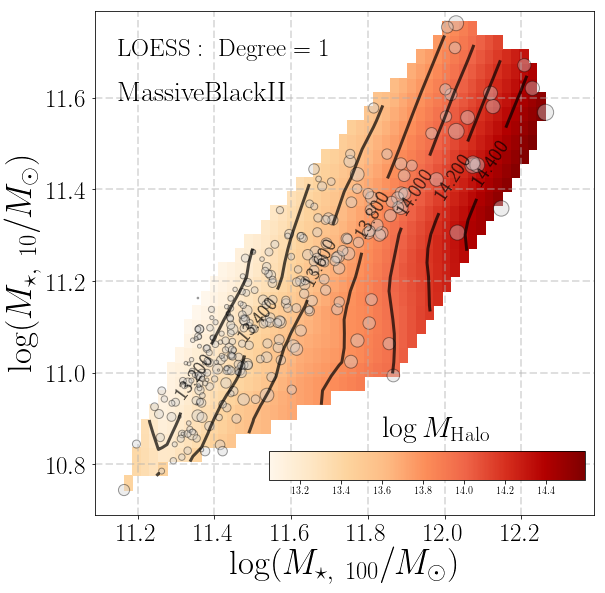

In [22]:
fig_1 = plt.figure(figsize=(8.3, 8))
fig_1.subplots_adjust(left=0.16, right=0.995, bottom=0.12, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

CS = ax1.contour(m100_grid, m10_grid, mhalo_grid, 8, 
                 linewidths=3.0, colors='k', alpha=0.7, extend='neither')

ax1.clabel(CS, inline=1, fontsize=20)

CM = ax1.pcolormesh(m100_grid, m10_grid, mhalo_grid, cmap='OrRd')

# Colorbar
cax = fig_1.add_axes([0.45, 0.18, 0.53, 0.05])
color_ticks = MaxNLocator(10).tick_values(mhalo_min, mhalo_max)
cbar = plt.colorbar(CM, cax=cax, ticks=color_ticks, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(11.84, 10.85, r'$\log M_{\rm Halo}$', size=30)

ax1.scatter(mb2_m100, mb2_m10, marker='o', s=(mb2_mhalo - 13.0) * 160,
            edgecolor='k', facecolor='lightgray', alpha=0.4, rasterized=True)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.4)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{100}}/M_{\odot})$', size=35)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{10}}/M_{\odot})$', size=35)

ax1.text(11.15, 11.69, r'$\mathrm{LOESS:\ Degree=1}$', size=25)
ax1.text(11.15, 11.59, r'$\mathrm{MassiveBlackII}$', size=28)

_ = ax1.set_xlim(11.09, 12.39)
_ = ax1.set_ylim(10.69, 11.79)

### M3D-M10-Mhalo relation

In [13]:
sig_mh = mb2_mhalo * 0.0 + 0.05
loess_mhalo, loess_weight = loess_2d(mb2_mstar, mb2_m10, mb2_mhalo, degree=1, sigz=sig_mh)

In [14]:
m100_min, m100_max = np.nanmin(mb2_mstar), np.nanmax(mb2_mstar)
m10_min, m10_max = np.nanmin(mb2_m10), np.nanmax(mb2_m10)
mhalo_min, mhalo_max = np.nanmin(loess_mhalo), np.nanmax(loess_mhalo)

color_levels = np.linspace(mhalo_min, mhalo_max, 100)

m100_grid = np.linspace(m100_min, m100_max, 50)
m10_grid = np.linspace(m10_min, m100_max, 50)

mhalo_grid = ml.griddata(mb2_mstar, mb2_m10, loess_mhalo, 
                         m100_grid, m10_grid, interp='linear')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
  # This is added back by InteractiveShellApp.init_path()


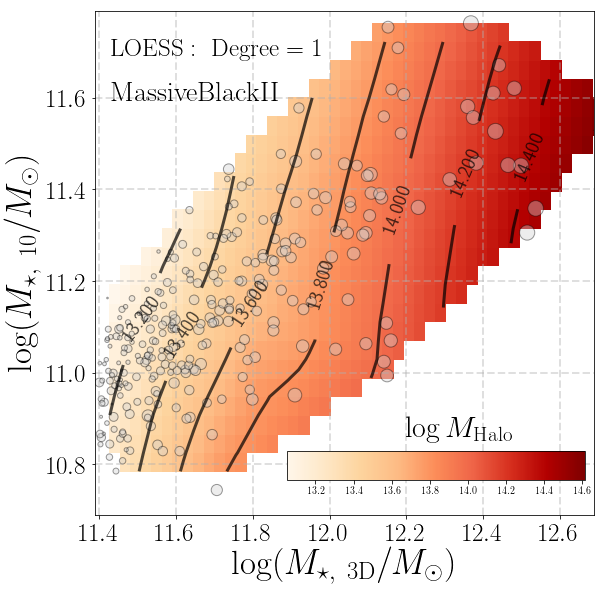

In [19]:
fig_2 = plt.figure(figsize=(8.3, 8))
fig_2.subplots_adjust(left=0.16, right=0.995, bottom=0.12, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_2.add_subplot(111)

CS = ax1.contour(m100_grid, m10_grid, mhalo_grid, 8, 
                 linewidths=3.0, colors='k', alpha=0.7, extend='neither')

ax1.clabel(CS, inline=1, fontsize=20)

CM = ax1.pcolormesh(m100_grid, m10_grid, mhalo_grid, cmap='OrRd')

# Colorbar
cax = fig_2.add_axes([0.48, 0.18, 0.50, 0.05])
color_ticks = MaxNLocator(10).tick_values(mhalo_min, mhalo_max)
cbar = plt.colorbar(CM, cax=cax, ticks=color_ticks, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(12.20, 10.85, r'$\log M_{\rm Halo}$', size=30)

ax1.scatter(mb2_mstar, mb2_m10, marker='o', s=(mb2_mhalo - 13.0) * 160,
            edgecolor='k', facecolor='lightgray', alpha=0.4, rasterized=True)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.4)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{3D}}/M_{\odot})$', size=35)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{10}}/M_{\odot})$', size=35)

ax1.text(11.43, 11.69, r'$\mathrm{LOESS:\ Degree=1}$', size=25)
ax1.text(11.43, 11.59, r'$\mathrm{MassiveBlackII}$', size=28)

_ = ax1.set_xlim(11.39, 12.69)
_ = ax1.set_ylim(10.69, 11.79)

### Save the figures

In [23]:
fig_1.savefig('fig/fig10.pdf', dpi=120)

fig_2.savefig('fig/fig10_b.pdf', dpi=120)